In [1]:
import pickle
import numpy as np
import pandas as pd

In [2]:
Asset_PATH = "/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/"

#### Load Gaussian KDE timeseries

In [3]:
density_matrix_t_series = pickle.load(open(Asset_PATH  + 'density_matrix_t_series_100x100.pickle', 'rb'))

In [4]:
density_matrix_t_series.shape

(198, 100, 100)

In [5]:
print(np.max(density_matrix_t_series))
print(np.min(density_matrix_t_series))

2019.7794007598727
-2.393156546274511e-13


In [6]:
density_matrix_t_series.shape[0]

198

In [7]:
timesteps = 52

In [8]:
train, valid = (60,20)
test = 20

total_len = density_matrix_t_series.shape[0] - timesteps
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

In [9]:
flattened_matrix_np = np.reshape(density_matrix_t_series, 
                                 (density_matrix_t_series.shape[0],
                                  density_matrix_t_series.shape[1]*density_matrix_t_series.shape[2]))
flattened_matrix_np.shape

(198, 10000)

In [10]:
np.max(flattened_matrix_np[train_index])

1935.6194220503628

In [11]:
scaler_max = np.max(flattened_matrix_np[train_index])
scaler_min = np.min(flattened_matrix_np[train_index])

X_train = (flattened_matrix_np[train_index] - scaler_min)/(scaler_max - scaler_min)


In [12]:
X_train = X_train.reshape(X_train.shape[0],
                          1,    
                          X_train.shape[1])
X_train.shape

(87, 1, 10000)

In [13]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],int(X_train.shape[2]**(1/2)),int(X_train.shape[2]**(1/2)),1)
X_train.shape

(87, 1, 100, 100, 1)

In [14]:
print(np.max(X_train))
print(np.min(X_train))

1.0
0.0


#### We transform the whole train, valid, test based on scaler fitted on train

In [15]:
np.max(flattened_matrix_np)

2019.7794007598727

In [16]:
flattened_matrix_np.dtype

dtype('float64')

In [17]:
scaled_flattened_matrix = (flattened_matrix_np - scaler_min)/(scaler_max - scaler_min)

In [18]:
flattened_matrix_np.shape

(198, 10000)

In [19]:
scaled_flattened_matrix.shape

(198, 10000)

In [20]:
print(np.max(scaled_flattened_matrix))
print(np.min(scaled_flattened_matrix))

1.0434796105839654
-3.2227207716804404e-17


In [21]:
scaled_flattened_matrix.shape

(198, 10000)

In [22]:
def window_stack(a, stepsize=1, width=52):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

In [23]:
stacked = window_stack(scaled_flattened_matrix,1,timesteps)

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
stacked.shape

(147, 520000)

In [25]:
reshape_stack = stacked.reshape(stacked.shape[0],timesteps,
                                int((stacked.shape[1]/timesteps)**(1/2)),
                                int((stacked.shape[1]/timesteps)**(1/2)),1)

In [26]:
reshape_stack.shape

(147, 52, 100, 100, 1)

#### We reshape to (sample, timestep, inputshape)

In [27]:
scaled_flattened_matrix = reshape_stack
scaled_flattened_matrix.shape

(147, 52, 100, 100, 1)

In [28]:
train, valid = (60,20)
test = 20

total_len = scaled_flattened_matrix.shape[0]
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

#### We set the target to be 7 days aggregated KDE or 1 single frame forward

In [29]:
X_train = scaled_flattened_matrix[np.array(train_index)]
Y_train = scaled_flattened_matrix[np.array(train_index)+1][:,-1,:]
Y_train = Y_train.reshape(Y_train.shape[0],int(Y_train.shape[1]*Y_train.shape[2]*Y_train.shape[3]))

In [30]:
X_valid = scaled_flattened_matrix[np.array(valid_index)]
Y_valid = scaled_flattened_matrix[np.array(valid_index)+1][:,-1,:]
Y_valid = Y_valid.reshape(Y_valid.shape[0],int(Y_valid.shape[1]*Y_valid.shape[2]*Y_valid.shape[3]))

In [31]:
X_test = scaled_flattened_matrix[np.array(test_index)]
Y_test = scaled_flattened_matrix[np.array(test_index)+1][:,-1,:]
Y_test = Y_test.reshape(Y_test.shape[0],int(Y_test.shape[1]*Y_test.shape[2]*Y_test.shape[3]))

In [32]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(88, 52, 100, 100, 1)
(88, 10000)
(28, 52, 100, 100, 1)
(28, 10000)
(28, 52, 100, 100, 1)
(28, 10000)


In [33]:
import os, datetime
import tensorflow as tf
from tensorflow.keras import optimizers
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GaussianNoise, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.layers import concatenate, Activation, Permute, Multiply, Lambda


In [34]:
checkpoint_filepath = Asset_PATH+'checkpoints/'
print(checkpoint_filepath)

/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/


## Flattened Fully Connected Model

In [132]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))
   
timeDist = TimeDistributed(Flatten())(inputs)

Dense1 = Dense(50, kernel_initializer='glorot_normal', activation='relu')(timeDist)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_Fully_Connected")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


Model: "Flattened_Fully_Connected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_73 (TimeDis (None, 52, 10000)         0         
_________________________________________________________________
dense_67 (Dense)             (None, 52, 50)            500050    
_________________________________________________________________
flatten_84 (Flatten)         (None, 2600)              0         
_________________________________________________________________
dense_68 (Dense)             (None, 10000)             26010000  
Total params: 26,510,050
Trainable params: 26,510,050
Non-trainable params: 0
_________________________________________________________________


## Flattened LSTM Model

In [104]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

    
timeDist = TimeDistributed(Flatten())(inputs)

LSTM_layer1 = LSTM(100)(timeDist)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)



Model: "Flattened_LTSM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_65 (TimeDis (None, 52, 10000)         0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 100)               4040400   
_________________________________________________________________
dense_54 (Dense)             (None, 100)               10100     
_________________________________________________________________
flatten_68 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 10000)             1010000   
Total params: 5,060,500
Trainable params: 5,060,500
Non-trainable params: 0
__________________________________________

## 2D CNN LSTM model

In [98]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
batch = 48
lr = .001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

cnn1 = Conv2D(20, (1,1), activation='relu', padding='same')
TD = TimeDistributed(cnn1)(inputs)

cnn2 = Conv2D(20, (1,1), activation='relu', padding='same')
TD2 = TimeDistributed(cnn2)(TD)

TD3 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD2)
    
timeDist = TimeDistributed(Flatten())(TD3)

cnn4 = Conv2D(20, (1,1), activation='relu', padding='same')
TD4 = TimeDistributed(cnn4)(TD3)

cnn5 = Conv2D(20, (1,1), activation='relu', padding='same')
TD5 = TimeDistributed(cnn5)(TD4)

TD6 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD5)
    
timeDist2 = TimeDistributed(Flatten())(TD6)

merge = concatenate([timeDist, timeDist2])

LSTM_layer1 = LSTM(50)(merge)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)



Model: "2DCNN_LTSM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_55 (TimeDistri (None, 52, 100, 100, 40          input_21[0][0]                   
__________________________________________________________________________________________________
time_distributed_56 (TimeDistri (None, 52, 100, 100, 420         time_distributed_55[0][0]        
__________________________________________________________________________________________________
time_distributed_57 (TimeDistri (None, 52, 50, 50, 2 0           time_distributed_56[0][0]        
_________________________________________________________________________________________

## 2D CNN with LSTM + Attention

In [36]:
from tensorflow.keras import backend as K

In [186]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))
'''
cnn1 = Conv2D(10, (1,1), activation='relu', padding='same')
TD = TimeDistributed(cnn1)(inputs)

cnn2 = Conv2D(10, (1,1), activation='relu', padding='same')
TD2 = TimeDistributed(cnn2)(TD)

TD3 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD2)
    
timeDist = TimeDistributed(Flatten())(TD3)
'''
'''
#Paralell 2D CNN layer
cnn4 = Conv2D(20, (1,1), activation='relu', padding='same')
TD4 = TimeDistributed(cnn4)(TD3)

cnn5 = Conv2D(20, (1,1), activation='relu', padding='same')
TD5 = TimeDistributed(cnn5)(TD4)

TD6 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD5)
    
timeDist2 = TimeDistributed(Flatten())(TD6)

merge = concatenate([timeDist, timeDist2])
'''

#send both convolved layer and flattened layer into LSTM
timeDist3 = TimeDistributed(Flatten())(inputs)
#merge = concatenate([timeDist, timeDist3])

units = 50
LSTM_layer1 = LSTM(units, return_sequences=True)(timeDist3)
# compute importance for each step
attention = Dense(1, activation='tanh')(LSTM_layer1)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)

print("attention shape", attention.shape)
print("LSTM_layer1 shape", LSTM_layer1.shape)
sent_representation = Multiply()([LSTM_layer1, attention])

print("sent_representation shape", sent_representation.shape)
#same shape as LSTM output (None,52,100)

#For each timestep update a single weight on Dense layer
attended_LSTM_out = TimeDistributed(Dense(1, activation='relu'))(sent_representation)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_LSTM_out))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM_Attention")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


attention shape (None, 52, 50)
LSTM_layer1 shape (None, 52, 50)
sent_representation shape (None, 52, 50)
Model: "2DCNN_LTSM_Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_94 (TimeDistri (None, 52, 10000)    0           input_43[0][0]                   
__________________________________________________________________________________________________
lstm_34 (LSTM)                  (None, 52, 50)       2010200     time_distributed_94[0][0]        
__________________________________________________________________________________________________
dense_99 (Dense)                (None, 52, 1)        51          lstm_34[

In [194]:
EPOCHS = 5

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=EPOCHS*1,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,)

logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cbk = tf.keras.callbacks.TensorBoard(log_dir=logdir)

modelfilename = checkpoint_filepath + '_'+\
                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\
                    + "_model.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelfilename,
    save_weights_only=False,
    monitor='val_loss',#'val_accuracy',
    mode='min',
    verbose=1,
    period = 1,
    save_best_only=True)



model_history = model.fit(X_train,Y_train, 
                             validation_data=(X_valid, Y_valid),
                             epochs=1000, 
                             batch_size=7, 
                             callbacks=[tensorboard_cbk,
                             #hp.KerasCallback(logdir, hparams),
                             earlystop_callback,
                             model_checkpoint_callback
                                       ]
                                   )
valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

Train on 88 samples, validate on 28 samples
Epoch 1/1000
70/88 [======================>.......] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00001: val_loss improved from inf to 0.00184, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200621-123345_model.hdf5
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 2/1000
70/88 [======================>.......] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00002: val_loss improved from 0.00184 to 0.00177, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200621-123345_model.hdf5
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 3/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.

### Best flatten() + LSTM(100) + Attention is at  MAE of 0.001739 

In [40]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 9176), started 18:11:18 ago. (Use '!kill 9176' to kill it.)

In [195]:
Predict = model.predict(X_valid)

In [196]:
Predict.shape

(28, 10000)

In [197]:
int(Predict[-1].shape[0]**(1/2)),int(Predict[-1].shape[0]**(1/2))

(100, 100)

In [198]:
def reshapePred(Predict, fromLast=1):
    return np.rot90(Predict[-1*fromLast].reshape(int(Predict[-1*fromLast].shape[0]**(1/2)),int(Predict[-1*fromLast].shape[0]**(1/2))))

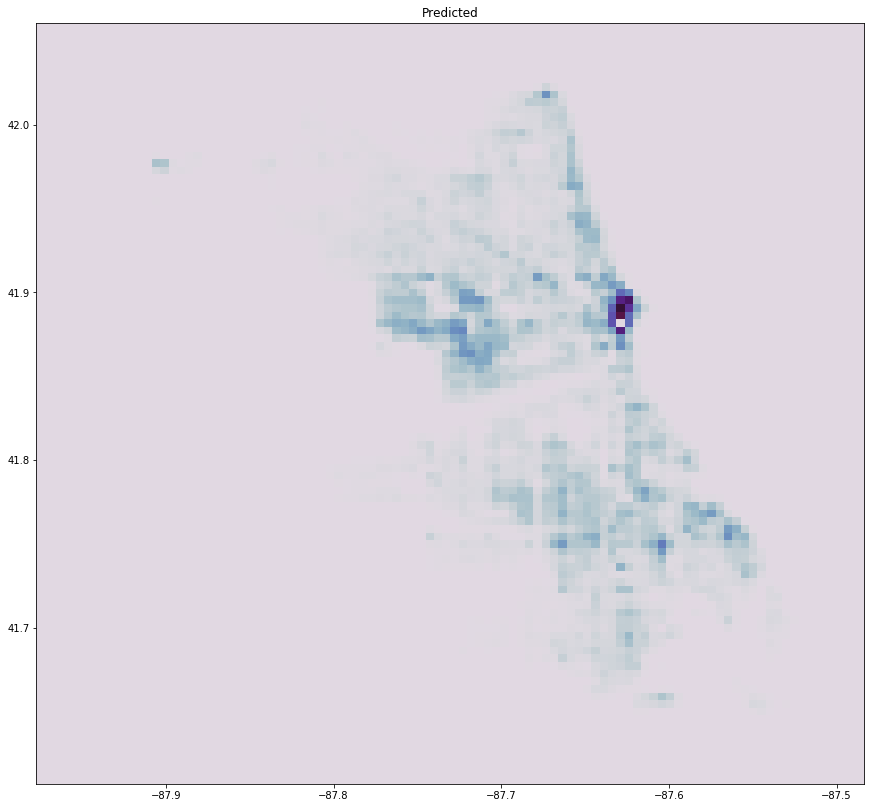

In [199]:
import matplotlib.pyplot as plt
grid_size = 500
density_matrix_t_series = []
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
plt.figure(figsize=(18, 14))
plt.title('Predicted')
plt.imshow( X=reshapePred(Predict,1), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

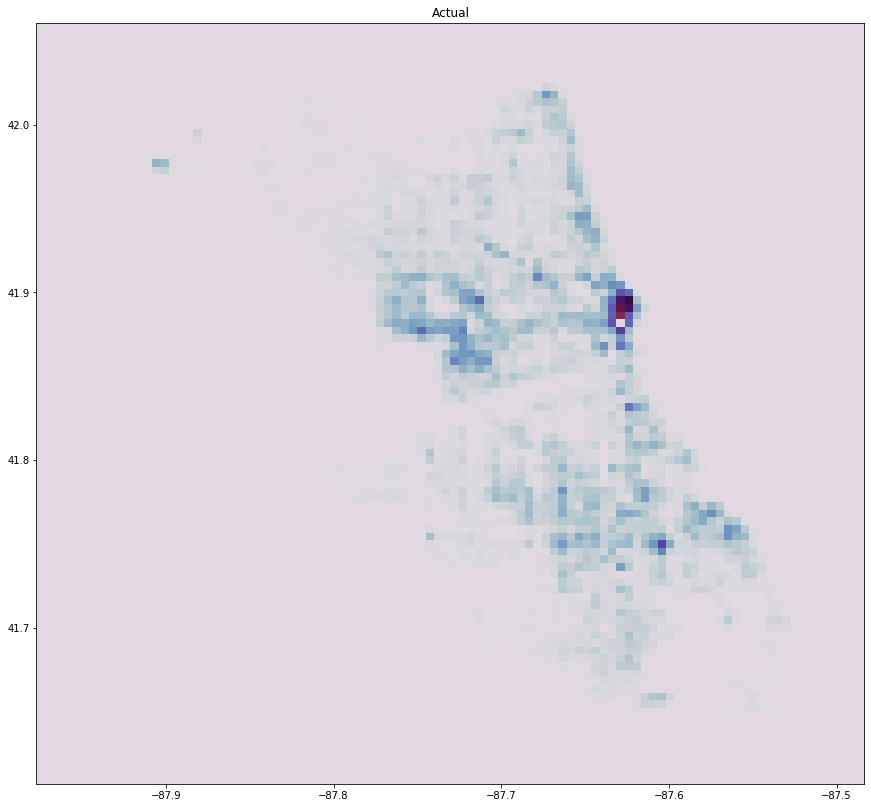

In [200]:
plt.figure(figsize=(18, 14))
plt.title('Actual')
plt.imshow( X=reshapePred(Y_valid,1), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])